# Interpoção do censo



## introdução.

A ideia é fazer uma interpolação do censo, de **microdados de domicilios de 1970**. 

In [1]:
#Importações/bibliotecas necessárias.
import pandas as pd
import geopandas as gpd
import time
import requests
import geopandas as gpd
from shapely.geometry import Point
from json.decoder import JSONDecodeError 
import geobr
import matplotlib.pyplot as plt
import h3
import contextily as ctx
import libpysal
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
from rtree import index

%load_ext watermark
%watermark -v -a "author: eli knaap" -d -u -p tobler,cenpy,geopandas

C:\Users\engce\anaconda3\Lib\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\engce\anaconda3\Lib\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\engce\anaconda3\Lib\site-packages\libpysal\cg\alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopyt

Author: author: eli knaap

Last updated: 2023-10-18

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.12.0

tobler   : 0.11.2
cenpy    : 1.0.1
geopandas: 0.14.0



## Qual é o contexto do censo?

A princípio é importante **definir o mapa**.

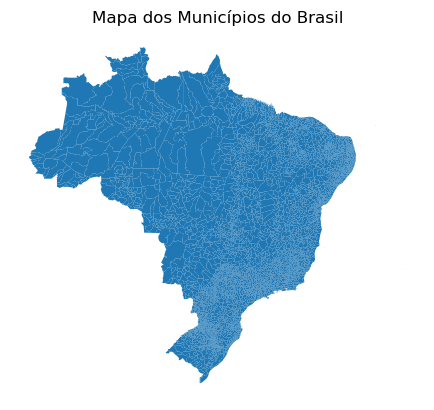

In [2]:
# Carregando o mapa dos municípios do Brasil a partir do Geobr.
municipios = geobr.read_municipality()

# Plotando o mapa dos municípios.
municipios.plot()
plt.title('Mapa dos Municípios do Brasil')
plt.axis('off')  
plt.show()

In [3]:
#Conferindo as 5 primeiras linhas do GeoDataFrame "municipios".
municipios.head()

,code_muni,name_muni,code_state,abbrev_state,geometry
0,1100015.0,Alta Floresta D'oeste,11.0,RO,"MULTIPOLYGON (((-62.24620 -11.90149, -62.24151..."
1,1100023.0,Ariquemes,11.0,RO,"MULTIPOLYGON (((-63.13712 -9.78413, -63.09013 ..."
2,1100031.0,Cabixi,11.0,RO,"MULTIPOLYGON (((-60.52408 -13.32137, -60.37161..."
3,1100049.0,Cacoal,11.0,RO,"MULTIPOLYGON (((-61.42679 -11.11376, -61.42900..."
4,1100056.0,Cerejeiras,11.0,RO,"MULTIPOLYGON (((-61.41347 -13.23417, -61.42603..."


# Quais são as informações do mapa?

As informações são dadas pelo objetivo do projeto, trabalhar com os dados do Censo de 1970. **O Censo pode ser pego no site https://basedosdados.org**.

## A partir do site, é possível baixar/importar os dados fácilmente!

In [4]:
#Subindo o arquivo do censo.
censo=pd.read_csv("C:\\Users\\engce\\OneDrive\\Documentos\\Estoque\\bquxjob_3efe2d9b_18b2a085728.csv")

In [5]:
#Lendo o arquivo, observando as 5 primeiras linhas.
censo.head()

,sigla_uf,id_municipio,id_domicilio,numero_familia,v001,v002,v003,v004,v005,v006,...,v013,v014,v015,v016,v017,v018,v019,v020,v021,v054
0,PA,1501402.0,91487,1,54,402,1,0,4,1,...,1,1,2,1,1,1,2,3,2,4.0
1,PA,1501402.0,78358,1,54,402,1,0,6,1,...,1,1,2,1,1,1,1,6,2,4.0
2,PA,1501402.0,73571,1,54,402,1,0,3,1,...,1,1,2,2,2,2,2,3,2,3.0
3,PA,1501402.0,75659,1,54,402,1,0,8,1,...,1,1,2,1,1,1,2,7,3,4.0
4,PA,1501402.0,81172,1,54,402,1,0,5,1,...,1,1,2,1,1,1,2,6,4,4.0


## Ué!? O que o censo tem a ver com o mapa do Brasil!?

O censo aqui são dados do próprio Brasil. Por isso, foi importante pegar o mapa do Brasil. Agora, é relacionar o GeoDataFrame 
do mapa, com o censo. Ou seja, **vizualizar melhor as delimitações que se encontra o censo**.

In [6]:
# Realize a junção dos dataframes com base nas colunas de código do município.
merged_df = municipios.merge(censo, left_on='code_muni', right_on='id_municipio', how='inner')



In [7]:
#Observando o GeoDataFrame.
merged_df.head()

,code_muni,name_muni,code_state,abbrev_state,geometry,sigla_uf,id_municipio,id_domicilio,numero_familia,v001,...,v013,v014,v015,v016,v017,v018,v019,v020,v021,v054
0,1100106.0,Guajará-Mirim,11.0,RO,"MULTIPOLYGON (((-65.25284 -10.99304, -65.25078...",RO,1100106.0,461,1,1,...,3,1,1,1,2,2,2,4,2,4.0
1,1100106.0,Guajará-Mirim,11.0,RO,"MULTIPOLYGON (((-65.25284 -10.99304, -65.25078...",RO,1100106.0,34,1,1,...,3,1,2,2,2,2,2,2,1,4.0
2,1100106.0,Guajará-Mirim,11.0,RO,"MULTIPOLYGON (((-65.25284 -10.99304, -65.25078...",RO,1100106.0,93,1,1,...,3,1,3,2,2,2,2,6,1,3.0
3,1100106.0,Guajará-Mirim,11.0,RO,"MULTIPOLYGON (((-65.25284 -10.99304, -65.25078...",RO,1100106.0,12,1,1,...,3,1,2,1,1,2,2,8,2,3.0
4,1100106.0,Guajará-Mirim,11.0,RO,"MULTIPOLYGON (((-65.25284 -10.99304, -65.25078...",RO,1100106.0,1283,1,1,...,5,2,6,2,2,2,2,3,2,3.0


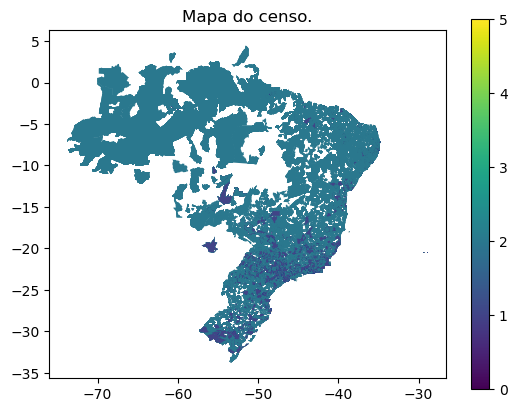

In [16]:
#Deixando claro a coluna geometry.
gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Plote o mapa.
gdf.plot(column='v018', cmap='viridis', legend=True)

# Adicione um título ao mapa.
plt.title('Mapa do censo.')

# Exiba o mapa
plt.show()


# É o suficiente?

O objetivo aqui, é fazer a interpolação. Assim, é necessário **transformar o mapa em hexagonos**. 

In [9]:
#Usando a biblíoteca h3fy para "interpolar" o mapa.
dc_hex = h3fy(gdf, resolution=5)

In [ ]:
#Observando o Mapa do hexadono.
dc_hex.head()

<Axes: >

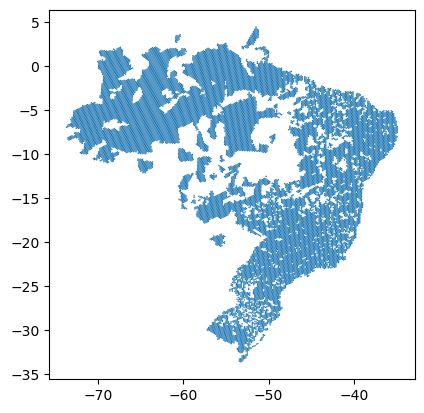

In [11]:
#Plotando o mapa formado por hexagonos.
dc_hex.plot()

## A interpolação foi feita?

 A interpolação ainda não está concluída. É preciso informar o mapa. O mapa feito por hexagonos, não contém informações do Censo.

In [13]:
#Concluindo a interpolação. Colocando informações.
dc_hex_interpolated = area_interpolate(source_df=gdf, target_df=dc_hex, intensive_variables=['v018'])

C:\Users\engce\AppData\Local\Temp\ipykernel_1008\2728771510.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dc_hex_interpolated = area_interpolate(source_df=gdf, target_df=dc_hex, intensive_variables=['v018'])


### A informação escolhida, do arquivo do Censo, foi a de número de televisores. A legenda das colunas são informadas no site onde foi pego o Censo.  Nesse caso, a coluna v018 é a que mostra o numero de televisores. 

# Pronto! 

C:\Users\engce\anaconda3\Lib\site-packages\mapclassify\classifiers.py:257: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  warnings.warn(
C:\Users\engce\anaconda3\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


Text(0.5, 0.98, 'Spatial Interpolation with the PySAL $\\mathtt{tobler}$ package')

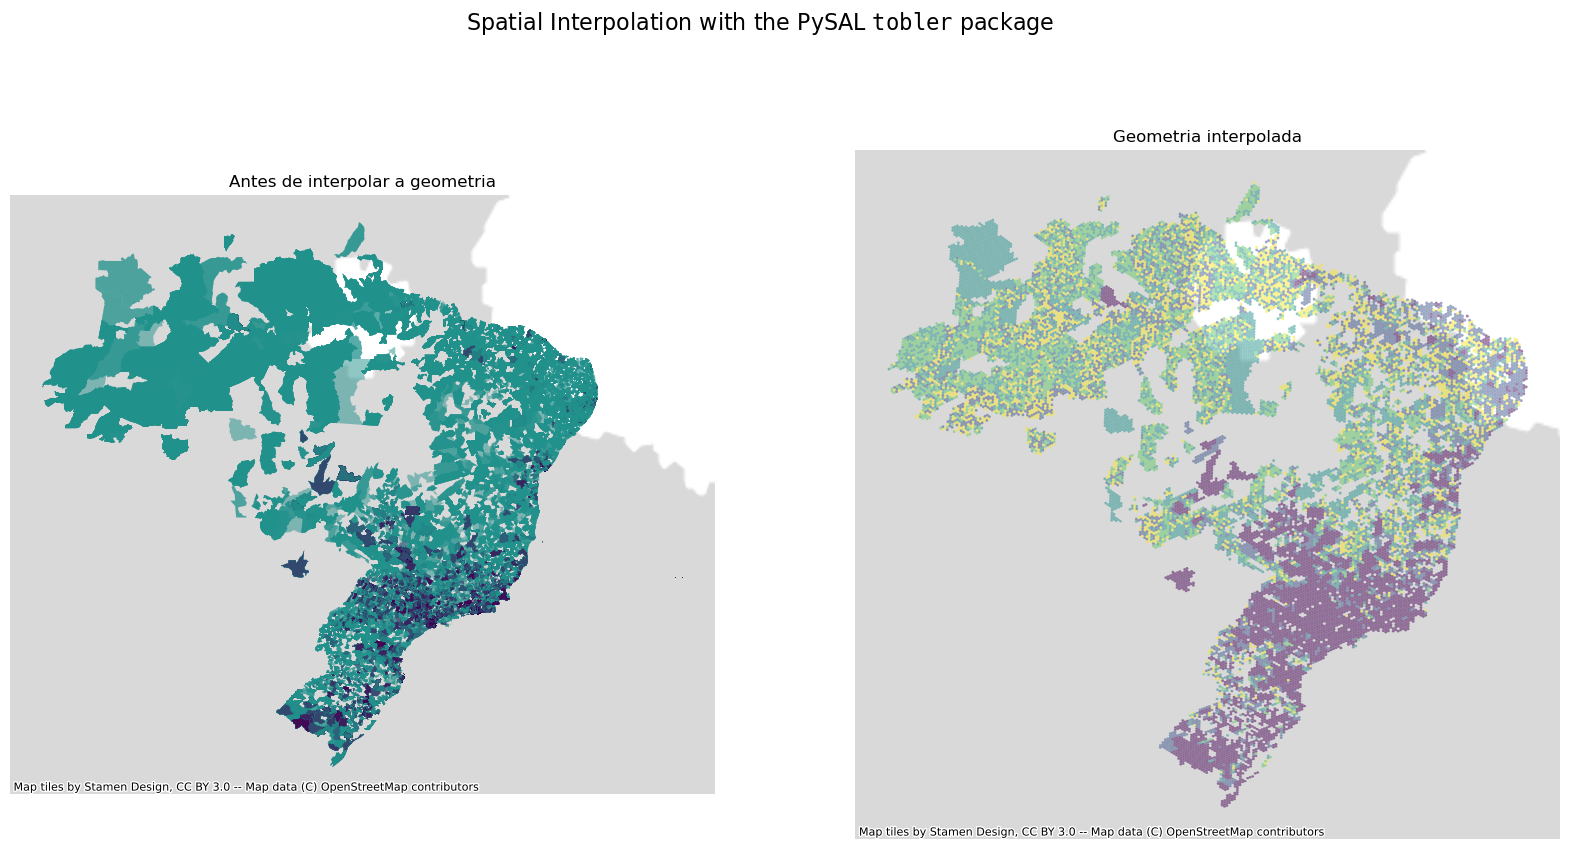

In [15]:

import mapclassify
fig, axs = plt.subplots(1,2, figsize=(20,10))
gdf.plot('v018', scheme='quantiles', alpha=0.5, ax=axs[0])
#Aqui é só um plote (Agora com a interpolação dos dados do v018).
dc_hex_interpolated.plot('v018', scheme='quantiles', alpha=0.5, ax=axs[1])
#os títulos dos mapas.
axs[0].set_title('Antes de interpolar a geometria')
axs[1].set_title('Geometria interpolada')

for ax in axs:
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
plt.suptitle('Spatial Interpolation with the PySAL $\mathtt{tobler}$ package', fontsize=16)

# Conclusão

A interpolação foi feita. A partir da interpolação, ficou mais fácil observar a distribuição do número de televisores.